<a href="https://colab.research.google.com/github/Intertangler/ML4biotech/blob/main/gmm_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

## excerise - fitting
### background story
We're analyzing a population of cells that we know to be a mixture of 3 distinct types. We've done some single cell sequencing analysis on the cells and want to be able to study the expression patterns of each individual cell. Fortunately, we know a particular gene whose expression level strongly predicts which cell type we're dealing with - low expression level of the gene is type 1 cell, medium expression is type 2, and high expression is type 3. The goal of this exercise is to classify each cell type according to expresison level by fitting a Gaussian mixture model (GMM) to the data from this gene.

### part 1 - fitting the Gaussian mixture model to the data with MLE
In this part, we are going to take a model (a mixture of multiple Gaussian PDFs) and adjust the parameters until the model best fits the data. The discovered parameters will tell us the average expression levels and relative spread of each of the cell subpopulations we are interested in.

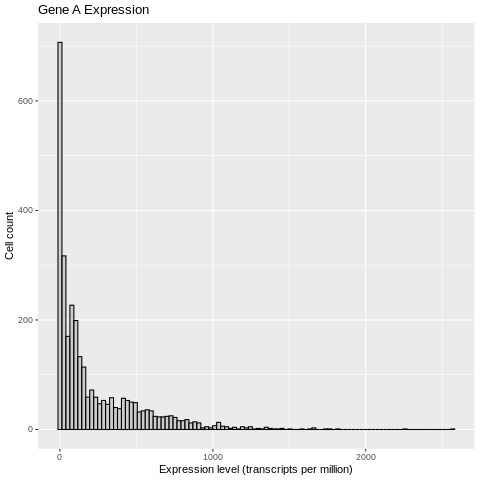

In [2]:
%%R

#First, let's import the data and transform it into something that we can fit a GMM to.
#As we often do, let's make a histogram to visualize the data.

library(ggplot2)

url <- "https://raw.githubusercontent.com/Intertangler/ML4biotech/main/gaussian_data_raw.csv"
data <- read.csv(url, header = FALSE)

data_vector <- as.numeric(unlist(data))

# Create a histogram
ggplot(data = data.frame(x = data_vector), aes(x = x)) +
  geom_histogram(bins = 100, fill = "grey", alpha = 0.7, colour = "black") +
  xlab('Expression level (transcripts per million)') +
  ylab('Cell count') +
  ggtitle('Gene A Expression')


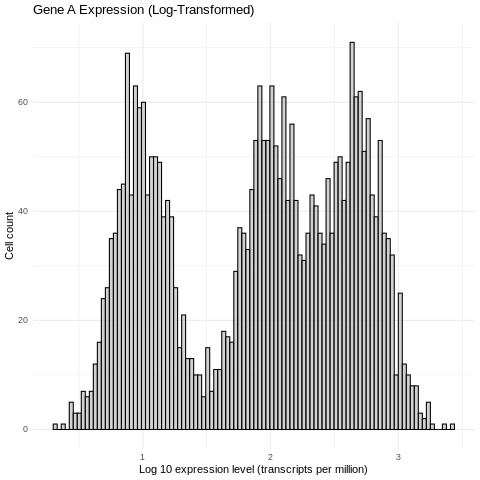

In [3]:
%%R

#In this experiment, the cell expression data (in transcripts per million) are lognormally
#distributed - and consequently these expression levels tend to be more spread out,
#the higher their values are. So, we will take the log of the data. If the data is
#indeed lognormally distributed, then this will have the effect of turning the data
#into normally (i.e. Gaussian) distributed data, that we will then be able to process with
#our GMM.

#🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟# # log 10 transform the data so that it is normally distributed

ggplot(data = data.frame(x = log_data), aes(x = x)) +
  geom_histogram(bins = 100, fill = "grey", alpha = 0.7, colour = "black") +
  xlab('Log 10 expression level (transcripts per million)') +
  ylab('Cell count') +
  ggtitle('Gene A Expression (Log-Transformed)') +
  theme_minimal()


In [4]:
%%R
#Next we want to fit a GMM to this now-Gaussian data. We will use the method of
#Maximum Likelihood Estimation. The requires us to have 1. a probability density
#function that enables us to compute probability densities for a given set of parameters.
#And 2. we need a loss function that the minimizer can use to find the right parameters.
#For this loss function, we will use the Negative Log Likelihood function NLL.


library(stats)
library(stats4)

# Make the gaussian mixture model probability density computing function
mixture_model_pdf <- function(data_point, params) {
  n_gaussians <- length(params) / 3
  pis <- params[1:n_gaussians]
  mus <- params[(n_gaussians+1):(2*n_gaussians)]
  sigmas <- params[(2*n_gaussians+1):(3*n_gaussians)]
  total_prob <- 0
  #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟# # loop through each of the gaussians
    #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#  #compute the probability density for each datapoint
  }
  return(total_prob)
}

# Define the NLL function - the loss function that we want to feed to the minimizer
nll <- function(params, data) {
  log_likelihood <- 0

  for (data_point in data) {
    density <- #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟# #fetch the probability density using the mixture model pdf function
    density <- density + 1e-10
    log_likelihood <- #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#  # compute the log of the probability density and add it to the overall likelihood
  }
  return(-log_likelihood)
}

# Load data from URL
url <- "https://raw.githubusercontent.com/Intertangler/ML4biotech/main/gaussian_data_raw.csv"
data <- read.csv(url, header = FALSE)
data_vector <- as.numeric(unlist(data))
log_data <- log10(data_vector)

# Initial guesses
initial_guess <- c(0.33, 0.33, 0.34, 1, 2, 5, 1, 1, 1)
lower_bounds <- c(1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12)
upper_bounds <- c(.33, .33, .33, Inf, Inf, Inf, Inf, Inf, Inf)


# run the optimizer
result <- optim(
  par = initial_guess,
  fn = nll,  # Your nll function here
  data = log_data,  # Your data here
  method = "L-BFGS-B",
  lower = lower_bounds,
  upper = upper_bounds,
  control = list(maxit = 10000)
)


In [5]:
%%R
print(result)

$par
[1] 0.3300000 0.3300000 0.3300000 2.0002392 0.9915295 2.6818491 0.2244617
[8] 0.2126931 0.2169265

$value
[1] 2643.57

$counts
function gradient 
      63       63 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"



In [ ]:
%%R
install.packages("ggplot2")
library(ggplot2)


In [ ]:
%%R

#If your minimization setup worked correctly, then when you run this cell, you will
#see Gaussian peaks fitted nicely to the data, with the sum of those peaks shown
#as well as their individual contributions.

visualize_data_and_model <- function(data, params) {
  data_frame <- data.frame(data = data)

  hist_data <- ggplot_build(ggplot(data_frame, aes(x = data)) +
                             geom_histogram(aes(y = ..density..), bins = 200, fill = 'blue'))$data[[1]]

  max_density <- max(hist_data$y)

  plot <- ggplot(data_frame, aes(x = data)) +
    geom_histogram(aes(y = ..density..), bins = 200, fill = 'blue') +
    labs(x = 'Data', y = 'Density', title = 'Data with Fitted Model Overlaid') +
    theme_minimal()

  n_gaussians <- length(params) %/% 3
  pi <- params[1:n_gaussians]
  mus <- params[(n_gaussians+1):(2*n_gaussians)]
  sigmas <- params[(2*n_gaussians+1):(3*n_gaussians)]

  x <- seq(min(data), max(data), length.out = 1000)
  y <- vector("list", n_gaussians)

  for(i in seq_len(n_gaussians)) {
    y[[i]] <- pi[i] * (1/(sigmas[i] * sqrt(2 * pi)) * exp(-0.5 * ((x - mus[i]) / sigmas[i])^2))
    y[[i]] <- y[[i]] / max(y[[i]]) * max_density
  }

  for(i in seq_len(n_gaussians)) {
    data_frame <- data.frame(x = x, y = y[[i]])
    plot <- plot +
            geom_line(data = data_frame, aes(x = x, y = y), color = 'black')
  }

  total_y <- Reduce('+', y)
  data_frame <- data.frame(x = x, y = total_y)

  plot <- plot +
        geom_line(data = data_frame, aes(x = x, y = y), color = 'red', linetype = "dashed")

  print(plot)
}

# Assuming result$par and log_data are defined
visualize_data_and_model(log_data, result$par)


In [ ]:
%%R

#Next, let's assign identities to each of the cells (data points) according to
#which Gaussian they are most probably belonging to. Since we have a probabilistic
#gaussian mixture model, this should let us compute the probability that any particular
#point on the axis of our random variable (gene expression level), or in other words
#each data point...is produced by one or other of the gaussians. For each point then
#we can compute 3 probabilities for each gaussian. The most likely gaussian becomes
#our decision then - and we assign that point to the respective gaussian. Some cells
#will be called with greater confidence than others - this is an advantage to this
#method over harder clustering methods like k-means.

assign_clusters <- function(data, params) {
  n_gaussians <- length(params) %/% 3
  pis <- params[1:n_gaussians]
  mus <- params[(n_gaussians+1):(2*n_gaussians)]
  sigmas <- params[(2*n_gaussians+1):(3*n_gaussians)]
  probabilities <- matrix(nrow = n_gaussians, ncol = length(data))

  for (i in 1:n_gaussians) {
    #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#  # make a loop that goes through each data point
      #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟# #compute the probability associated with each data point with respect to each gaussian and update the table
    }
  }

  probabilities <- probabilities / rowSums(probabilities)

  return(probabilities)
}

visualize_clusters_and_model <- function(data, params, probabilities) {
  n_gaussians <- length(params) %/% 3
  pis <- params[1:n_gaussians]
  mus <- params[(n_gaussians+1):(2*n_gaussians)]
  sigmas <- params[(2*n_gaussians+1):(3*n_gaussians)]

  x <- seq(min(data), max(data), length.out = 1000)
  y <- vector("list", n_gaussians)

  plot(x, pis[1] * (1/(sigmas[1] * sqrt(2 * pi)) * exp(-0.5 * ((x - mus[1]) / sigmas[1])^2)),
       type = "n",
       xlim = c(min(data), max(data)),
       ylim = c(-0.001, max(sapply(1:n_gaussians, function(i) pis[i] * (1/(sigmas[i] * sqrt(2 * pi)))))),
       xlab = "Data",
       ylab = "Density",
       main = "Data with Fitted Model and Cluster Probabilities")

  for(i in 1:n_gaussians) {
    y[[i]] <- pis[i] * (1/(sigmas[i] * sqrt(2 * pi)) * exp(-0.5 * ((x - mus[i]) / sigmas[i])^2))
    lines(x, y[[i]], col = "black", lwd = 2)
  }

  cluster_assignments <- apply(probabilities, 2, which.max)
  colors <- rainbow(n_gaussians)[cluster_assignments]

  points(data, rep(-0.001, length(data)), pch = 19, col = colors, cex = 0.5)

  legend("topright", legend = paste("Gaussian", 1:n_gaussians), col = "black", lwd = 2)
}



# Assuming log_data and result$par are defined
predicted_probabilities <- assign_clusters(log_data, result$par)
predicted_labels <- apply(predicted_probabilities, 2, which.max)

visualize_clusters_and_model(log_data, result$par, predicted_probabilities)


In [ ]:
%%R
install.packages("mclust")
install.packages("ggplot2")
install.packages("MASS")
install.packages("ellipse")

install.packages("mixtools")

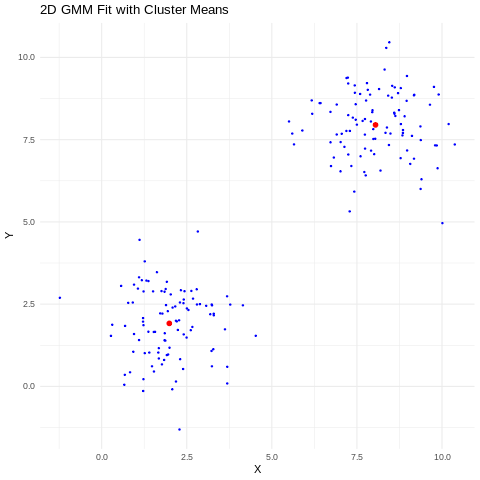

In [60]:
%%R
library(MASS)
library(ellipse)

fit_gmm <- function(data, n_gaussians, n_iterations) {
  n <- nrow(data)
  d <- ncol(data)
  data <- as.matrix(data) # Convert data frame to matrix

  # Step 1: Initialize the parameters
  set.seed(123)
  weights <- rep(1/n_gaussians, n_gaussians)
  means <- data[sample(1:n, n_gaussians, replace = FALSE),]
  sigmas <- array(0, dim = c(d, d, n_gaussians))
  for (i in 1:n_gaussians) {
    sigmas[,,i] <- diag(d)
  }

  # Step 2: EM algorithm
  for (iteration in 1:n_iterations) {
    # E-step: Compute the responsibilities using the current parameter values
    resp <- matrix(0, nrow = n, ncol = n_gaussians)
    for (i in 1:n_gaussians) {
      resp[,i] <- weights[i] * dmvnorm(data, means[i,], sigmas[,,i])
    }
    resp <- resp / rowSums(resp)

    # M-step: Update the parameter values using the current responsibilities
    for (i in 1:n_gaussians) {
      Nk <- sum(resp[,i])
      weights[i] <- Nk / n
      means[i,] <- colSums(resp[,i] * data) / Nk
      sigma_temp <- t(data - matrix(means[i,], n, d, byrow = TRUE)) %*% diag(resp[,i]) %*% (data - matrix(means[i,], n, d, byrow = TRUE)) / Nk
      sigmas[,,i] <- sigma_temp
    }
  }

  list(weights = weights, means = means, sigmas = sigmas, resp = resp)
}

# Usage example:
data <- data.frame(V1 = c(rnorm(100, 2, 1), rnorm(100, 8, 1)), V2 = c(rnorm(100, 2, 1), rnorm(100, 8, 1)))
gmm_results <- fit_gmm(data, 2, 100)
#print(gmm_results)

# Visualization:
ggplot(data, aes(x = V1, y = V2)) +
  geom_point(color = 'blue', size = 0.5) +
  geom_point(data = as.data.frame(gmm_results$means), aes(x = V1, y = V2), color = 'red', size = 2) +
  ggtitle('2D GMM Fit with Cluster Means') +
  xlab('X') +
  ylab('Y') +
  theme_minimal()
